In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg

In [2]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/healthcare-dataset-stroke-data.csv")
application_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
application_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


##    Variance features Distribution

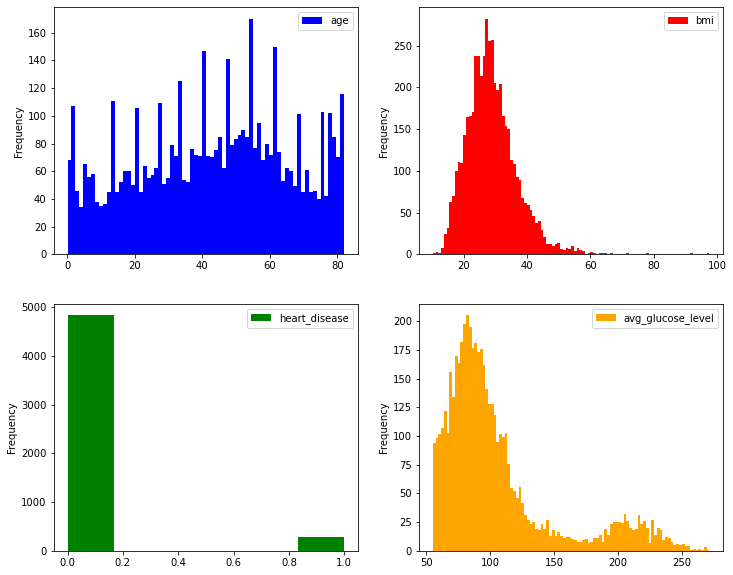

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
application_df.plot(kind="hist", y="age", bins=70, color="b", ax=axes[0][0])
application_df.plot(kind="hist", y="bmi", bins=100, color="r", ax=axes[0][1])
application_df.plot(kind="hist", y="heart_disease", bins=6, color="g", ax=axes[1][0])
application_df.plot(kind="hist", y="avg_glucose_level", bins=100, color="orange", ax=axes[1][1])
plt.show()

<ol>
  <li>We have good distribution for age .</li> 
  <li>I think we have outliers in bmi .</li>
  <li>Avg glucose distribution is reasonable because the normal avg of blood in sugar is less than 140 ,                that may be not good this feature will not be helpful to know if diabetes have correlation between                  diabetes and strokes</li>
</ol>    

### Data Summary ( Check for missing values )

In [6]:
print ("Rows     : " , application_df.shape[0])
print ("Columns  : " , application_df.shape[1])
print ("\nFeatures : \n" , application_df.columns.tolist())
print ("\nMissing values :  ", application_df.isnull().sum().values.sum())
print ("\nUnique values :  \n",application_df.nunique())


Rows     :  5110
Columns  :  12

Features : 
 ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Missing values :   201

Unique values :  
 id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64


## Data Visualization

### Stroke Pie Chart

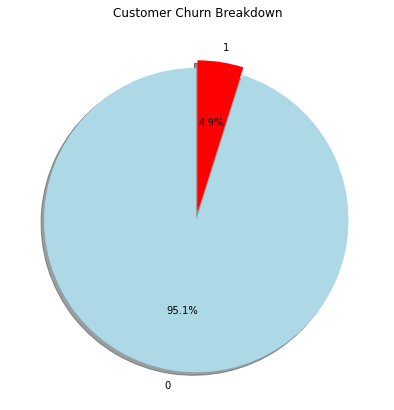

In [7]:
labels = application_df['stroke'].value_counts(sort = True).index
sizes = application_df['stroke'].value_counts(sort = True)

colors = ["lightblue","red"]
explode = (0.05,0) 
 
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Customer Churn Breakdown')
plt.show()

#### . Only 5% percent of people have Stroke !

## Gender 

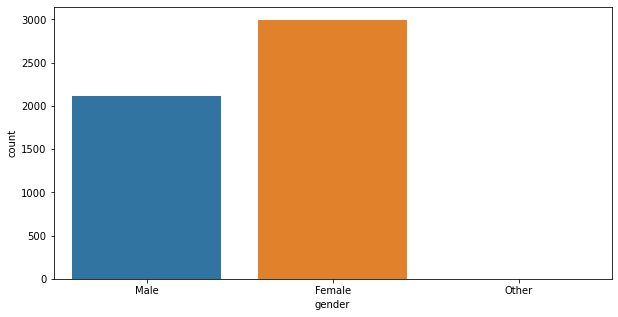

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(data=application_df,x='gender');

#### . There is about 1000 diffrence between Female and Male in the data

### Correlation with avg glucose level

##### . Visualize some features which maybe have correlation with avg glucose level

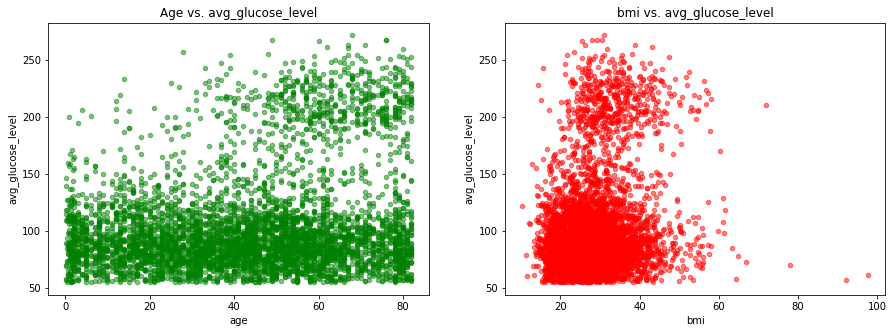

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
application_df.plot(kind='scatter', x='age', y='avg_glucose_level', alpha=0.5, color='green', ax=axes[0], title="Age vs. avg_glucose_level")
application_df.plot(kind='scatter', x='bmi', y='avg_glucose_level', alpha=0.5, color='red', ax=axes[1], title="bmi vs. avg_glucose_level")
plt.show()

#### . Avg glucose level is high with old people
#### . BMI >40 have low avg glucose

### Stroke Or not Pair Grid

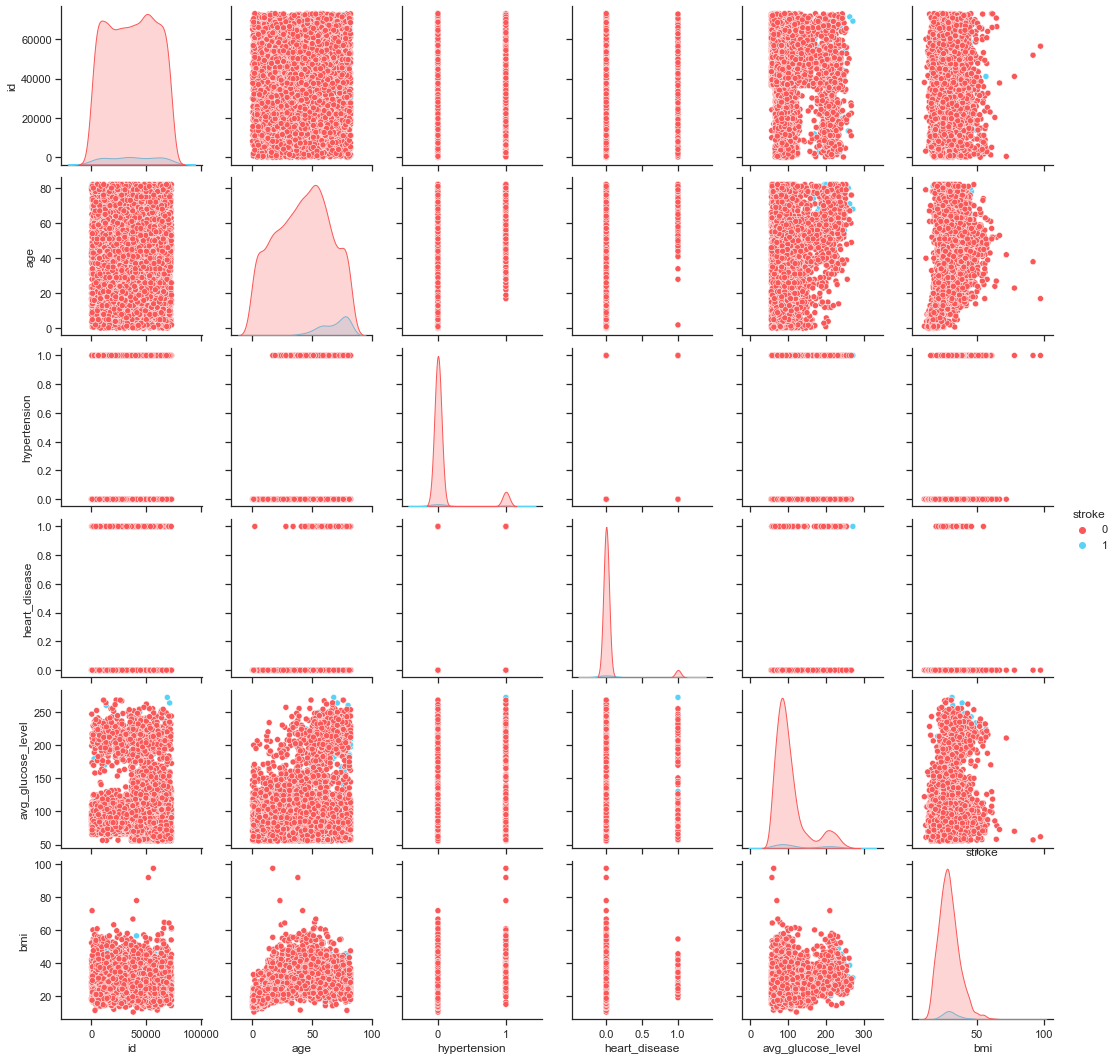

In [10]:
sns.set(style="ticks");
pal = ["#FA5858", "#58D3F7"]

sns.pairplot(application_df, hue="stroke", palette=pal);
plt.title("stroke");

### Heatmap Correlation

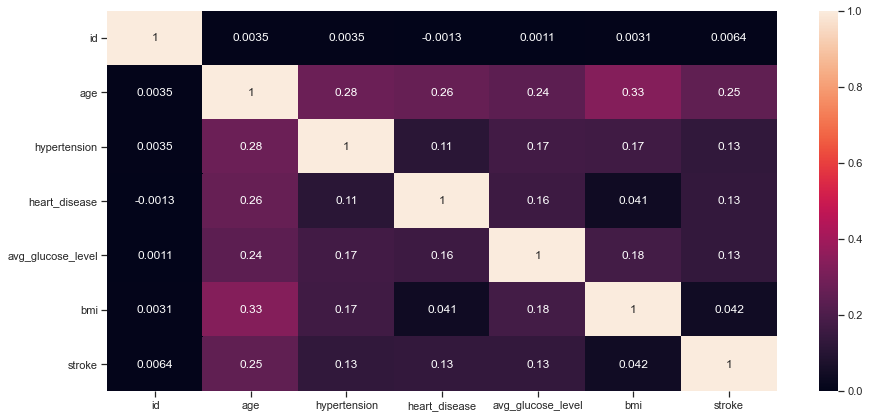

In [11]:
plt.figure(figsize=(15,7))
sns.heatmap(application_df.corr(),annot=True);

#### . There is no correlation between stroke and BMI

### BMI Boxplot

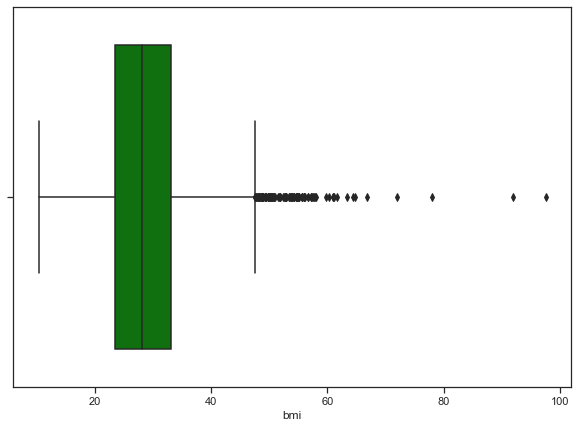

In [12]:
plt.figure(figsize=(10,7))
sns.boxplot(data=application_df,x=application_df["bmi"],color='green');

#### . We have many outliers but before we fix this we must study BMI first

### <h1 style='color :White'><center style='background:Black'>**BMI**</center></h1>

#### . Body mass index is a value derived from the mass and height of a person

<!-- <img src="image/BMI 2.JPG"> -->

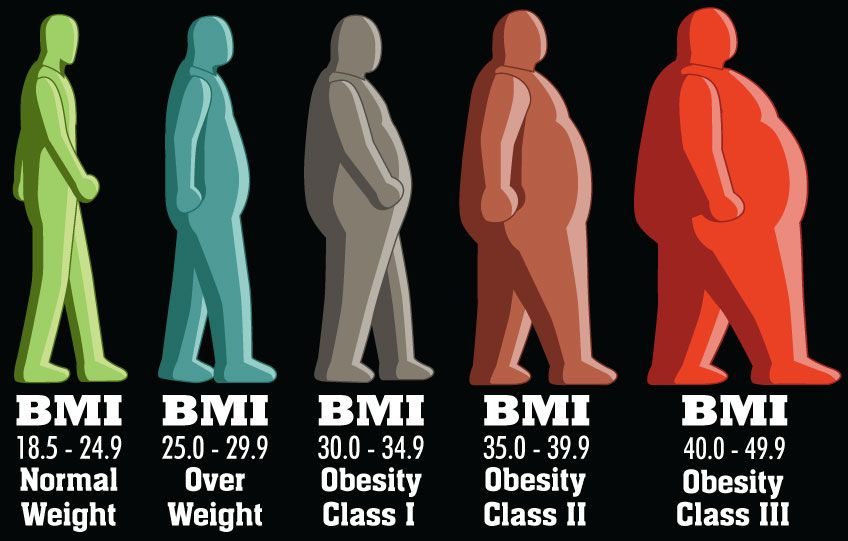

In [13]:
bmi_outliers=application_df.loc[application_df['bmi']>50]
bmi_outliers['bmi'].shape

(79,)

In [14]:
# Mean with outliers
print(bmi_outliers['stroke'].value_counts())

0    78
1     1
Name: stroke, dtype: int64


In [15]:
# application_df['bmi'] = application_df['bmi'].apply(lambda x: 50 if x>50 else x)

In [16]:
# Drop nun
application_df = application_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

## Double Check for missing values

In [17]:
print('\nMissing values : ',application_df.isnull().sum().values.sum())


Missing values :  0


## Stroke or not in Categorical Features

In [18]:
cat_df = application_df[['gender','Residence_type','smoking_status','stroke']]
summary = pd.concat([pd.crosstab(cat_df[x], cat_df.stroke) for x in cat_df.columns[:-1]], keys=cat_df.columns[:-1])
summary

stroke                             0    1
gender         Female           2777  120
               Male             1922   89
               Other               1    0
Residence_type Rural            2319  100
               Urban            2381  109
smoking_status Unknown          1454   29
               formerly smoked   780   57
               never smoked     1768   84
               smokes            698   39

## Stroke/Ever Married

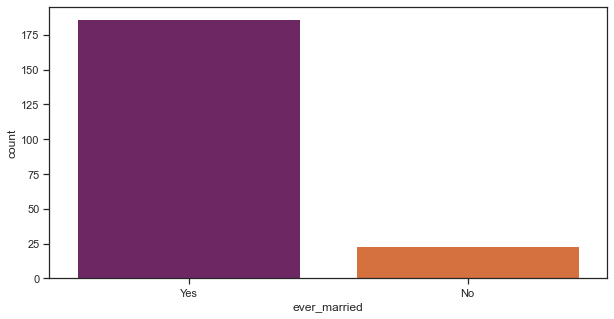

In [19]:
plt.figure(figsize=(10,5))
strok=application_df.loc[application_df['stroke']==1]
sns.countplot(data=strok,x='ever_married',palette='inferno');

## Stroke/Work Type

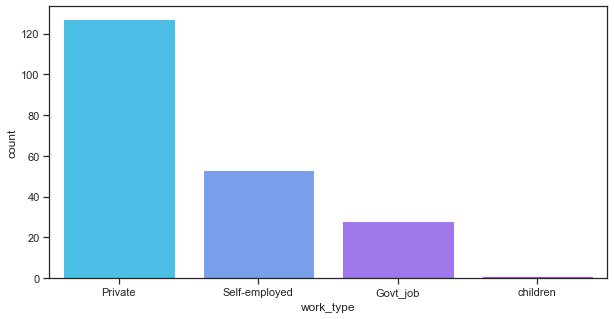

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(data=strok,x='work_type',palette='cool');

#### . Private work exposes you to more stroke

## Stroke/Smoking Status

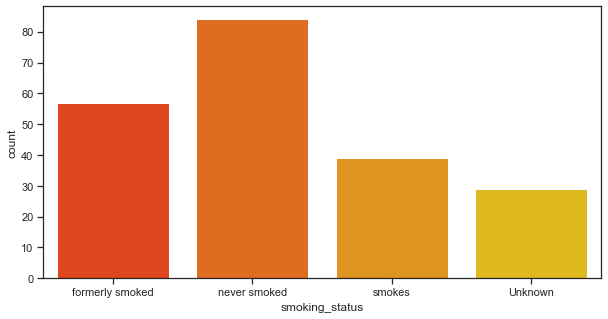

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(data=strok,x='smoking_status',palette='autumn');

#### . Being a smoker or a formerly smoker increases your risk of having a stroke

## Residence Type

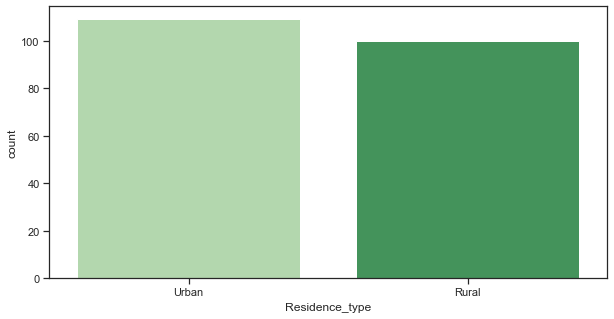

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(data=strok,x='Residence_type',palette='Greens');

## Stroke/Heart Disease

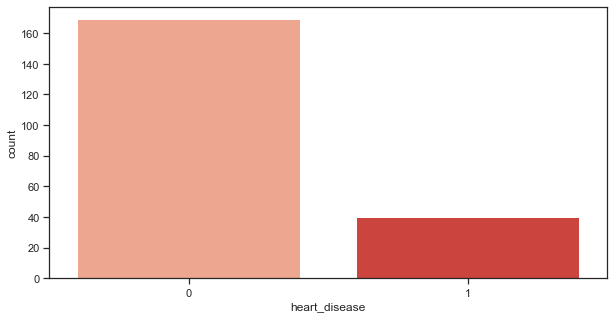

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(data=strok,x='heart_disease',palette='Reds');

#### . Most people who have had a stroke do not have any heart disease, but that does not prevent it being an influential factor

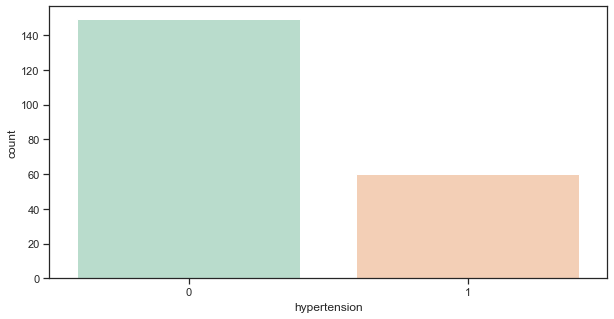

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(data=strok,x='hypertension',palette='Pastel2');

#### . more than 25% of strok cases They had hypertension

### <h1 style='color :White'><center style='background:#008080'>**Notes**</center></h1>

<ol>
  <li>Avg glucose level is high with old people .</li> 
  <li>BMI >40 have low avg glucose .</li>
  <li>Being unmarried reduces your risk of a stroke</li>
  <li>Being a smoker or a formerly smoker increases your risk of having a stroke</li>
  <li>more than 25% of strok cases They had hypertension</li>
</ol>    

### <h1 style='color :White'><center style='background:#000080'>**Data Preprocessing**</center></h1>

## Encoding Categorical Features

In [25]:
application_df["Residence_type"] = application_df["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
application_df["ever_married"] = application_df["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
application_df["gender"] = application_df["gender"].apply(lambda x: 1 if x=="Male" else 0)

C:\Users\Amr\anaconda3\envs\pythonDataTF\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Amr\anaconda3\envs\pythonDataTF\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Amr\anaconda3\envs\pythonDataTF\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [26]:
application_df = pd.get_dummies(data=application_df, columns=['smoking_status'])
application_df = pd.get_dummies(data=application_df, columns=['work_type'])

In [27]:
application_df

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,0,0,1,0,0
2,31112,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,1,0,0
3,60182,0,49.0,0,0,1,1,171.23,34.4,1,0,0,0,1,0,0,1,0,0
4,1665,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,0,0,1,0
5,56669,1,81.0,0,0,1,1,186.21,29.0,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,0,13.0,0,0,0,0,103.08,18.6,0,1,0,0,0,0,0,0,0,1
5106,44873,0,81.0,0,0,1,1,125.20,40.0,0,0,0,1,0,0,0,0,1,0
5107,19723,0,35.0,0,0,1,0,82.99,30.6,0,0,0,1,0,0,0,0,1,0
5108,37544,1,51.0,0,0,1,0,166.29,25.6,0,0,1,0,0,0,0,1,0,0


### Scaling The variance in Features

In [28]:
std=StandardScaler()
columns = ['avg_glucose_level','bmi','age']
scaled = std.fit_transform(application_df[['avg_glucose_level','bmi','age']])
scaled = pd.DataFrame(scaled,columns=columns)
application_df=application_df.drop(columns=columns,axis=1)

In [29]:
application_df=application_df.merge(scaled, left_index=True, right_index=True, how = "left")
application_df

,id,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
0,9046,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,2.777698,0.981345,1.070138
2,31112,1,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1.484132,0.701207,0.272012
3,60182,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1.549193,-0.623083,1.602222
4,1665,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1.821368,0.013595,1.690903
5,56669,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,-0.792780,-0.190142,1.380520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN
5106,44873,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,NaN,NaN,NaN
5107,19723,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,NaN,NaN,NaN
5108,37544,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,NaN,NaN,NaN


### Drop ID feature and check for nulls

In [30]:
application_df=application_df.drop(columns='id',axis=1)

In [31]:
application_df[application_df.isnull().any(axis=1)]

,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
4909,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,NaN,NaN,NaN
4910,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN
4911,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,NaN,NaN,NaN
4912,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,NaN,NaN,NaN
4913,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN
5106,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,NaN,NaN,NaN
5107,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,NaN,NaN,NaN
5108,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,NaN,NaN,NaN


### <h1 style='color :White'><center style='background:#000080'>**Classification Models**</center></h1>

### Target & Features

In [32]:
# Drop nun
X_application_df =application_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [33]:
X = X_application_df.drop(['stroke'], axis=1)
y = X_application_df['stroke'].values

In [34]:
X.shape
y.shape

(4717,)

### Splitting

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### SVM

In [36]:
svc = SVC(random_state=0)
svc.fit(X_train, y_train)
#== 
#Score 
#== 
svc_score = svc.score(X_train, y_train)
svc_test = svc.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = svc.predict(X_test)
#== 
#evaluation
#== 
# cm = confusion_matrix(y_test,y_pred)
print('Training Score',svc_score)
print('Testing Score \n',svc_test)
# print(cm)

Training Score 0.9572856710087853
Testing Score 
 0.9519774011299436


### Random Forest Classifier

In [37]:
forest = RandomForestClassifier(n_estimators = 100)
#== 
forest.fit(X_train, y_train)
#== 
#Score 
#== 
forest_score = forest.score(X_train, y_train)
forest_test = forest.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = forest.predict(X_test)
#== 
#evaluation
#== 
# cm = confusion_matrix(y_test,y_pred)
print('Training Score',forest_score)
print('Testing Score \n',forest_test)
# print(cm)

Training Score 1.0
Testing Score 
 0.9498587570621468


In [39]:
# X_application_df.to_csv('Stroke_data.csv')